In [59]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import imageio

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init
from torch.optim import lr_scheduler
import torch.utils.data
#import torchvision.transforms as transforms
import os

In [60]:
#Utils
def display3DObject(test_object):   
    print("Displaying the object")
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.voxels(test_object, edgecolor='k')
    plt.show()
    
def addNoise(shape, noise=0.1):
    #print(shape)
    return Variable(torch.zeros(shape).normal_(0, noise).cuda())

In [61]:
import math
def logsumexp(value, dim=None, keepdim=False):
    """Numerically stable implementation of the operation
    value.exp().sum(dim, keepdim).log()
    """
    if dim is not None:
        m, _ = torch.max(value, dim=dim, keepdim=True)
        value0 = value - m
        if keepdim is False:
            m = m.squeeze(dim)
        return m + torch.log(torch.sum(torch.exp(value0),
                                       dim=dim, keepdim=keepdim))
    else:
        m = torch.max(value)
        sum_exp = torch.sum(torch.exp(value - m))
        if isinstance(sum_exp, Number):
            return m + math.log(sum_exp)
        else:
            return m + torch.log(sum_exp)

In [62]:
def log_density(sample, mu, logsigma):
    normalization = Variable(torch.Tensor([np.log(2 * np.pi)]), requires_grad = False)
    c = normalization.type_as(sample.data)
    inv_sigma = torch.exp(-logsigma)
    tmp = (sample - mu) * inv_sigma
    return -0.5 * (tmp * tmp + 2 * logsigma + c)

In [63]:
# load images
images = np.load('chair_images.npy')
voxels = np.load('chair_voxels_filtered_0.npy')

# preprocessing
preprocessed_images = []
for subimages in images:
    preprocessed_subimages = np.array([(subimage - np.mean(subimage))/np.std(subimage) for subimage in subimages])
    preprocessed_images.append(preprocessed_subimages)
preprocessed_images = np.stack(preprocessed_images)

# reshuffle order
np.random.seed(42)
reseq = np.random.choice(len(images), len(images), replace=False)
preprocessed_images = np.array([preprocessed_images[i] for i in reseq])
voxels = np.array([voxels[i] for i in reseq])

train_images = preprocessed_images[:-130]
val_images = preprocessed_images[-130:-100]
test_images = preprocessed_images[-100:]
train_voxels = voxels[:-130]
val_voxels = voxels[-130:-100]
test_voxels = voxels[-100:]

In [64]:
# loading

batch_size = 5

train_data = [train_voxels, train_images]
val_data = [val_voxels, val_images]
test_data = [test_voxels, test_images]

for _ in range(len(train_data)):
    train_data[_] = torch.from_numpy(train_data[_]).type(torch.FloatTensor)
    train_data[_] = train_data[_].cuda()
    
for _ in range(len(val_data)):
    val_data[_] = torch.from_numpy(val_data[_]).type(torch.FloatTensor)
    val_data[_] = val_data[_].cuda()
    
for _ in range(len(test_data)):
    test_data[_] = torch.from_numpy(test_data[_]).type(torch.FloatTensor)
    test_data[_] = test_data[_].cuda()

train_data = [(train_data[0][i], train_data[1][i]) for i in range(len(train_data[0]))]
test_data = [(test_data[0][i], test_data[1][i]) for i in range(len(test_data[0]))]


train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, shuffle=True, drop_last=True)

Displaying the object


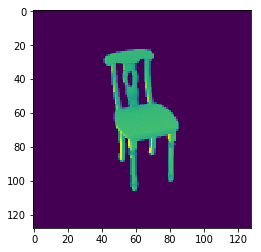

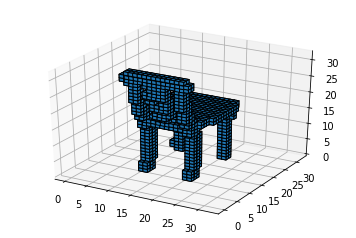

In [65]:
display_id = 56
plt.imshow(train_images[display_id][0])
display3DObject(train_voxels[display_id])

In [66]:
class Encoder2d(nn.Module):
    def __init__(self, input_nc=1, output_nc=200, ngf=8, norm_layer=nn.BatchNorm2d,\
                 use_dropout=False, padding_type='reflect'):
        super(Encoder2d, self).__init__()
        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        model = [nn.ReflectionPad2d(2),
                 nn.Conv2d(input_nc, ngf, kernel_size=5, padding=0,
                           bias=use_bias),
                 norm_layer(ngf),
                 nn.ReLU(True)]
        
        
        n_downsampling = 4
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=5,
                                stride=2, padding=1, bias=use_bias),
                      norm_layer(ngf * mult * 2),
                      nn.ReLU(True)]
        
        for i in range(2):
            model += [nn.Conv2d(ngf * mult * 2, ngf * mult * 2, kernel_size=3,
                                    stride=2, padding=1, bias=use_bias),
                          norm_layer(ngf * mult * 2),
                          nn.ReLU(True)]
            
        model += [nn.Conv2d(ngf * mult * 2, output_nc, kernel_size=2,
                                    stride=1, padding=0, bias=use_bias)]
        model += [nn.Tanh()]
        
            
        

#         mult = 2**(n_downsampling-1)
#         for i in range(n_blocks):
#             model += [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer,\
#                                   use_dropout=use_dropout, use_bias=use_bias)]
            
        self.model = nn.ModuleList(model)
#         self.model = nn.Sequential(*model)

    def forward(self, x):
        for model in self.model:
            x = model(x)
#             print(x.size())
        return x
        #return self.model(input)

In [159]:
class VAE(nn.Module):
    def __init__(self, input_nc=1, z_size=200, ndf=25, cube_size=32):
        super(VAE, self).__init__()
        self.encoderLayer1 = torch.nn.Sequential(
            torch.nn.Conv2d(input_nc, ndf, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf),
            torch.nn.ReLU()
        )
        
        self.encoderLayer2 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf, ndf*2, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf*2),
            torch.nn.ReLU()
        )
        
        self.encoderLayer3 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf*2, ndf*4, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf*4),
            torch.nn.ReLU()
        )
        
        self.encoderLayer4 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf*4, ndf*8, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf*8),
            torch.nn.ReLU()
        )
        
        self.encoderLayer5 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf*8, ndf*8, kernel_size=4, stride=4, padding=1),
            torch.nn.BatchNorm2d(ndf*8),
            torch.nn.ReLU()
        )
        
        self.encoderLayer6 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf*8, ndf*8, kernel_size=4, stride=2, padding=1),
            torch.nn.Tanh()
        )
        
        self.z_size = z_size
        self.cube_size = cube_size
        
        self.fc1 = nn.Linear(ndf*8, self.z_size)
        self.fc2 = nn.Linear(ndf*8, self.z_size)
        
        self.decoderLayer1 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.z_size, self.cube_size*4, kernel_size=4, stride=2, padding=(0,0,0)),
            torch.nn.BatchNorm3d(self.cube_size*4),
            torch.nn.ReLU()
        )
        
        self.decoderLayer2 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.cube_size*4, self.cube_size*2, kernel_size=4, stride=2, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_size*2),
            torch.nn.ReLU()
        )
        self.decoderLayer3 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.cube_size*2, self.cube_size*1, kernel_size=4, stride=2, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_size*1),
            torch.nn.ReLU()
        )

        self.decoderLayer4 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.cube_size, 1, kernel_size=4, stride=2,  padding=(1, 1, 1)),
            torch.nn.Sigmoid()
        )
        
    def encoder(self, x): 
        out = self.encoderLayer1(x)
        out = self.encoderLayer2(out)
        out = self.encoderLayer3(out)
        out = self.encoderLayer4(out)
        out = self.encoderLayer5(out)
        out = self.encoderLayer6(out).view(-1, self.z_size)
        return self.fc1(out), self.fc2(out)
    
    #source: https://github.com/bhpfelix/Variational-Autoencoder-PyTorch/blob/master/src/vanila_vae.py
    def reparametrize(self, mu, logsigma):
        std = logsigma.exp_()
        eps = torch.cuda.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)
    
    def decoder(self, x):
        out = self.decoderLayer1(x)
        out = self.decoderLayer2(out)
        out = self.decoderLayer3(out)
        out = self.decoderLayer4(out)
        return out
    
    def forward(self, x):
        mu, logsigma = self.encoder(x)
        latent = self.reparametrize(mu, logsigma)
        latent = latent.view(-1,self.z_size,1,1,1)#latent.unsqueeze(2).unsqueeze(2).unsqueeze(2)
        
        object_3D = self.decoder(latent)
        return object_3D, mu, logsigma
    

In [160]:
vae = VAE()
vae.cuda()
dis3d = discriminator()
dis3d.cuda()

discriminator(
  (layer1): Sequential(
    (0): Conv3d(1, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True)
    (2): LeakyReLU(0.2)
  )
  (layer2): Sequential(
    (0): Conv3d(32, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): LeakyReLU(0.2)
  )
  (layer3): Sequential(
    (0): Conv3d(64, 128, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True)
    (2): LeakyReLU(0.2)
  )
  (layer4): Sequential(
    (0): Conv3d(128, 256, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True)
    (2): LeakyReLU(0.2)
  )
  (layer5): Sequential(
    (0): Conv3d(256, 1, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (1): Sigmoid(

In [161]:
# hyperparameters
z_size = 200
learning_rate = 0.0025
# adam_beta = (0.5, 0.99)
solver = optim.Adam(vae.parameters(), lr=learning_rate)

In [162]:
def save_model(epoch):
    state_dicts = {'vae': vae.state_dict(), 'solver': solver.state_dict(), 'loss': losses_mean, \
                   'rec_loss': rec_losses_mean} 
    
    folder = 'tcvae_checkpoints'
    filename = 'epoch_{}.pt'.format(epoch)
    
    try:
        os.mkdir(folder)
    except:
        pass
    
    torch.save(state_dicts, os.path.join(folder, filename))


In [163]:
_logqz

Variable containing:
( 0 ,.,.) = 
 -1.9858 -1.9007 -2.0542  ...  -2.0238 -1.8848 -1.9750
 -1.9958 -1.8640 -1.9269  ...  -2.0418 -1.8626 -1.9252
 -2.0212 -1.9229 -1.9757  ...  -2.0520 -1.9540 -2.0460
 -2.1028 -1.8419 -1.9740  ...  -1.9845 -1.9195 -2.0696
 -2.0063 -1.8399 -1.8695  ...  -1.9489 -1.9169 -2.0442

( 1 ,.,.) = 
 -2.0653 -2.1732 -2.1045  ...  -2.0597 -1.8835 -1.9498
 -2.0671 -2.1326 -1.9753  ...  -2.0746 -1.8832 -1.8837
 -2.0890 -2.1689 -2.0316  ...  -2.0859 -1.9690 -2.0210
 -2.1761 -2.1334 -2.0207  ...  -2.0230 -1.9210 -2.0401
 -2.0917 -2.1195 -1.9234  ...  -1.9903 -1.9448 -2.0118

( 2 ,.,.) = 
 -1.9752 -1.9082 -2.0608  ...  -1.9421 -1.9134 -2.3870
 -1.9842 -1.8702 -1.9282  ...  -1.9761 -1.8866 -2.4235
 -2.0103 -1.9289 -1.9822  ...  -1.9707 -1.9744 -2.4099
 -2.0962 -1.8492 -1.9764  ...  -1.9059 -1.9453 -2.4319
 -1.9977 -1.8461 -1.8708  ...  -1.8709 -1.9358 -2.4301

( 3 ,.,.) = 
 -2.0205 -2.0504 -2.1422  ...  -1.8942 -1.9366 -1.9790
 -2.0245 -2.0486 -2.0194  ...  -1.9256 -1.90

In [164]:
def load_model(path):
    state_dicts = torch.load(path)
    vae.load_state_dict(state_dicts['vae'])
    solver.load_state_dict(state_dicts['solver'])

In [165]:
zs

Variable containing:
 5.1971e+01  2.1529e+09 -4.9849e+07  ...   3.8565e+08 -1.1034e+09  2.6414e+09
 5.1971e+01  4.6858e+08  4.2469e+08  ...  -6.3383e+08  1.7889e+08  1.0847e+09
 5.1971e+01 -1.0990e+09  9.6628e+08  ...  -3.3098e+08  7.6883e+08 -6.6066e+08
 5.1971e+01  5.6559e+07  5.6830e+08  ...  -7.1584e+08 -7.9538e+08 -1.9311e+09
 5.1971e+01 -7.7509e+08 -2.0931e+08  ...   2.6833e+05  3.3681e+08  4.8441e+08
[torch.cuda.FloatTensor of size 5x200 (GPU 0)]

In [170]:
def elbo(x, x_params, zs, mu, logsigma,  dataset_size, tcvae = True, beta=1., lamb = 0, include_mutinfo= True):
#     log p(x|z) + log p(z) - log q(z|x)
    batch_size = zs.size(0)
    z_dim = zs.size(1)
    prior_mu, prior_logsigma = Variable(torch.zeros(zs.size())).cuda(), Variable(torch.zeros(zs.size())).cuda()
    
    eps = 1e-8
    logpx = ((x_params+eps).log()*(x) + (1-x_params+eps).log()*(1-x)).sum(dim=-1).sum(-1).sum(-1)

    logpz = log_density(zs, prior_mu,prior_logsigma).view(batch_size, -1).sum(1)
    logqz_condx = log_density(zs, mu, logsigma).view(batch_size, -1).sum(1)

    elbo = logpx + logpz - logqz_condx

    if not tcvae:
        return elbo, elbo.detach(), logpx

    # compute log q(z) ~= log 1/(NM) sum_m=1^M q(z|x_m) = - log(MN) + logsumexp_m(q(z|x_m))

    _logqz = log_density(
        zs.view(batch_size, 1, z_dim),
        mu.unsqueeze(0), logsigma.unsqueeze(0)
    )

    # minibatch importance sampling
    logqz_prodmarginals = (logsumexp(_logqz, dim=1, keepdim=False) - math.log(batch_size * dataset_size)).sum(1)

    logqz = (logsumexp(_logqz.sum(2), dim=1, keepdim=False) - math.log(batch_size * dataset_size))
    mutinfo = logqz_condx - logqz
    total_cor = logqz - logqz_prodmarginals
    dim_kl =  logqz_prodmarginals - logpz
    if include_mutinfo:
        
        modified_elbo = logpx - \
            mutinfo - \
            beta * total_cor - \
            (1 - lamb) * dim_kl
    else:
        modified_elbo = logpx - \
            beta * total_cor - \
            (1 - lamb) * dim_kl

    return -modified_elbo, elbo.detach(), logpx, mutinfo, total_cor, dim_kl

In [171]:
logqz_prodmarginals

Variable containing:
-1828.7908
-1828.7435
-1830.9326
-1829.4005
-1827.8411
[torch.cuda.FloatTensor of size 5 (GPU 0)]

In [172]:
logpz

Variable containing:
-397.3701
-397.2607
-399.1837
-397.7313
-396.5555
[torch.cuda.FloatTensor of size 5 (GPU 0)]

In [173]:
#Training the system
num_epochs = 100

Losses = []
Rec_Losses = []
    

for epoch in range(num_epochs):
# for epoch in range(101,120):
    losses = []
    rec_losses = []
    for batch_idx, (data3d, data2d) in enumerate(train_loader):
        var_3D_data = Variable(data3d.float(), requires_grad=False)
        
        indices = torch.from_numpy(np.random.randint(12, size = batch_size))
        indices = indices.unsqueeze(1).unsqueeze(2).expand(-1,128,128).unsqueeze(1).cuda()
        data2d = torch.gather(data2d, dim = 1, index=indices).squeeze()
        var_2D_data = Variable(data2d.float().unsqueeze(1), requires_grad = False)
        
        mu, logsigma = vae.encoder(var_2D_data)
        zs = vae.reparametrize(mu,logsigma)
        x_params = vae.decoder(zs.view(-1,z_size,1,1,1))
        
        x_params = x_params.squeeze()
        
        #loss 
        loss, elbo_term, logpx, mutinfo, total_cor, dim_kl = elbo(var_3D_data, x_params, zs, mu, logsigma,  \
                                                                  dataset_size, tcvae = True, beta=1., \
                                                                  lamb = 0, include_mutinfo= True)
        
        solver.zero_grad()
        loss.mean().backward()
        solver.step()
        
        losses.append(loss.mean().data.cpu().numpy())
        rec_losses.append(logpx.mean().data.cpu().numpy())
    
    losses_mean = np.mean(np.concatenate(losses))
    rec_losses_mean = np.mean(np.concatenate(rec_losses))
    
    print("Epoch: ", epoch)
    
    print(' loss: ', losses_mean, 'rec_loss: ', rec_losses_mean)
    
    Losses.append(losses_mean)
    Rec_Losses.append(rec_losses_mean)
    
    # validation
    data3d, data2d = val_data
    data2d = data2d[:,1].unsqueeze(1)
    
    var_3D_data = Variable(data3d.cuda().float(), requires_grad=False)
    var_2D_data = Variable(data2d.cuda().float(), requires_grad=False)
    
    mu, logsigma = vae.encoder(var_2D_data)
    zs = vae.reparametrize(mu,logsigma)
    x_params = vae.decoder(zs.view(-1,z_size,1,1,1))

    x_params = x_params.squeeze()

    #loss 
    loss, elbo_term, logpx, mutinfo, total_cor, dim_kl = elbo(var_3D_data, x_params, zs, mu, logsigma,\
                                                              dataset_size, tcvae = True, beta=1., \
                                                              lamb = 0, include_mutinfo= True)
    
    
    print(' valid loss: ', loss.mean().data.cpu().numpy(), 'valid rec_loss: ', logpx.mean().data.cpu().numpy())
    
    # test model saving
    save_model(epoch)
    folder = 'tcvae_checkpoints'
    filename = 'epoch_{}.pt'.format(epoch)
    path = os.path.join(folder, filename)
    load_model(path)

Epoch:  0
 loss:  4650.61 rec_loss:  -4631.58
 valid loss:  [ 5400.41748047] valid rec_loss:  [-5390.30566406]
Epoch:  1
 loss:  4443.99 rec_loss:  -4463.44
 valid loss:  [ 5366.47753906] valid rec_loss:  [-5396.98876953]
Epoch:  2
 loss:  4314.43 rec_loss:  -4334.54
 valid loss:  [ 4904.96582031] valid rec_loss:  [-4941.28271484]
Epoch:  3
 loss:  4171.57 rec_loss:  -4203.46
 valid loss:  [ 5180.05566406] valid rec_loss:  [-5210.87011719]
Epoch:  4
 loss:  4139.0 rec_loss:  -4161.87
 valid loss:  [ 4858.60253906] valid rec_loss:  [-4897.50097656]


KeyboardInterrupt: 

In [ ]:
# yet to fix the rest

In [99]:
# test: single sample vs multiview greeedy vs multiview probabilistic
for epoch in range(80,100):
    folder = 'vae3dgan_checkpoints'
    filename = 'epoch_{}.pt'.format(epoch)
    path = os.path.join(folder, filename)
    load_model(path)

    singleview_rec_losses = []
    multiview_greedy_rec_losses = []
    multiview_exact_rec_losses = []
    var_list = []
    greedy_var_list = []
    exact_var_list = []

    for i in range(len(test_data)):
        data3d, data2d = test_data[i]
        data2d = data2d.unsqueeze(1)

        var_3D_data = Variable(data3d.cuda().float(), requires_grad=False).unsqueeze(0)
        var_2D_data = Variable(data2d.cuda().float(), requires_grad=False)
        mu, logvar = vae.encoder(var_2D_data)

        # single view reconstructions
        latents = mu.view(-1,vae.z_size,1,1,1)
#         generated_objects = vae.decoder(latents)
#         generated_objects= generated_objects.squeeze()


#         rec_loss = loss(generated_objects, var_3D_data.repeat(data2d.size()[0],1,1,1))/data2d.size()[0]
#         rec_loss = rec_loss.data.cpu().numpy()
        sub_rec_losses = []
        for latent in latents:
            generated_object = vae.decoder(latent.unsqueeze(0))
            generated_object= generated_object.squeeze().unsqueeze(0)
            sub_rec_loss = loss(generated_object, var_3D_data).data.cpu().numpy()    
            sub_rec_losses.append(sub_rec_loss)
        rec_loss = min(sub_rec_losses)
    

        var_mean = logvar.exp().mean(0).data.cpu().numpy()
        singleview_rec_losses.append(rec_loss)
        var_list .append(var_mean)


        # multiview greedy
        greedy_indices = torch.min(logvar, dim=0)[1]
        greedy_mu = mu.gather(0, greedy_indices.view(1,-1))
        greedy_logvar = logvar.gather(0, greedy_indices.view(1,-1))
        greedy_latent = greedy_mu.view(-1,vae.z_size,1,1,1)#latent.unsqueeze(2).unsqueeze(2).unsqueeze(2)
        generated_object = vae.decoder(greedy_latent)
        generated_object = generated_object.squeeze().unsqueeze(0)

        rec_loss = loss(generated_object, var_3D_data)
        rec_loss = rec_loss.data.cpu().numpy()

        greedy_var = greedy_logvar.exp().data.cpu().numpy()
        multiview_greedy_rec_losses.append(rec_loss)
        greedy_var_list.append(greedy_var)

        # multiview exact with many assumptions...
        numerator_var = 1/((1/(logvar.exp())).sum(dim=0))
        numerator_mean = (mu/(logvar.exp())).sum(dim=0)*numerator_var
        denom_var = 1/(mu.size()[0]-1)
        denom_mean = 0

        exact_mu = numerator_mean*denom_var/(denom_var-numerator_var)
        exact_var = (numerator_var*denom_var/(denom_var-numerator_var)).data.cpu().numpy()
#         if np.mean(exact_var) <0:
#             print('model not right')
#             print(exact_var)

        exact_latent = exact_mu.view(-1,vae.z_size,1,1,1)
        generated_object = vae.decoder(exact_latent)
        generated_object = generated_object.squeeze().unsqueeze(0)

        rec_loss = loss(generated_object, var_3D_data)
        rec_loss = rec_loss.data.cpu().numpy()

        multiview_exact_rec_losses.append(rec_loss)
        exact_var_list.append(exact_var)

    var_list = np.stack(var_list)
    greedy_var_list = np.stack(greedy_var_list)
    exact_var_list = np.stack(exact_var_list)

    print(epoch)
    
    print('single view average')
    print(np.mean(var_list))
    print(sum(singleview_rec_losses)/len(singleview_rec_losses))
    print('multiview greedy')
    print(np.mean(greedy_var_list))
    print(sum(multiview_greedy_rec_losses)/len(multiview_greedy_rec_losses))
    print('multiview exact')
    print(np.mean(exact_var_list))
    print(sum(multiview_exact_rec_losses)/len(multiview_exact_rec_losses))


80
single view average
0.553044
[ 2679.02539062]
multiview greedy
0.354769
[ 2977.68554688]
multiview exact
0.160999
[ 3850.30615234]
81
single view average
0.527641
[ 2725.66870117]
multiview greedy
0.347507
[ 3052.68676758]
multiview exact
0.138005
[ 3570.80151367]
82
single view average
0.52832
[ 2662.19067383]
multiview greedy
0.350242
[ 2965.08374023]
multiview exact
0.129543
[ 3242.33007812]
83
single view average
0.57824
[ 2723.2043457]
multiview greedy
0.380419
[ 3038.12744141]
multiview exact
-0.0342259
[ 3951.48876953]
84
single view average
0.562423
[ 2671.06152344]
multiview greedy
0.36719
[ 3040.59863281]
multiview exact
0.0958818
[ 3992.90625]
85
single view average
0.557776
[ 2671.94287109]
multiview greedy
0.359754
[ 3056.10180664]
multiview exact
0.126085
[ 4011.79101562]
86
single view average
0.559222
[ 2679.6027832]
multiview greedy
0.379459
[ 2977.45751953]
multiview exact
0.158509
[ 3773.8425293]
87
single view average
0.53089
[ 2717.34130859]
multiview greedy
0.3

In [ ]:
 for i in range(3):
    data3d, data2d = test_data[i]
    data2d = data2d.unsqueeze(1)

    var_3D_data = Variable(data3d.cuda().float(), requires_grad=False).unsqueeze(0)
    var_2D_data = Variable(data2d.cuda().float(), requires_grad=False)
    mu, logvar = vae.encoder(var_2D_data)

    # single view reconstructions
    latents = mu.view(-1,vae.z_size,1,1,1)
#         generated_objects = vae.decoder(latents)
#         generated_objects= generated_objects.squeeze()


#         rec_loss = loss(generated_objects, var_3D_data.repeat(data2d.size()[0],1,1,1))/data2d.size()[0]
#         rec_loss = rec_loss.data.cpu().numpy()
    sub_rec_losses = []
    for latent in latents:
        generated_object = vae.decoder(latent.unsqueeze(0))
        generated_object= generated_object.squeeze().unsqueeze(0)
        sub_rec_loss = loss(generated_object, var_3D_data).data.cpu().numpy()    
        sub_rec_losses.append(sub_rec_loss)
    rec_loss = np.min(np.array(sub_rec_losses))
    


    var_mean = logvar.exp().mean(0).data.cpu().numpy()
    singleview_rec_losses.append(rec_loss)
    var_list .append(var_mean)

33
Real Image
torch.Size([1, 1, 128, 128])
Displaying the object


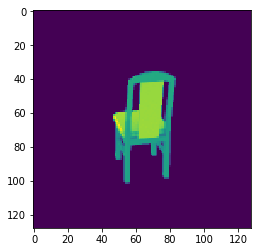

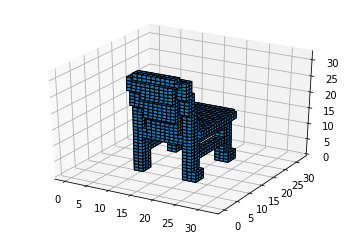

Predicted 3D object
Displaying the object


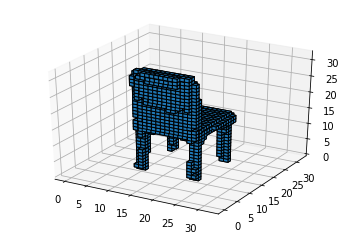

90
Real Image
torch.Size([1, 1, 128, 128])
Displaying the object


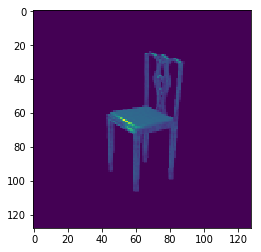

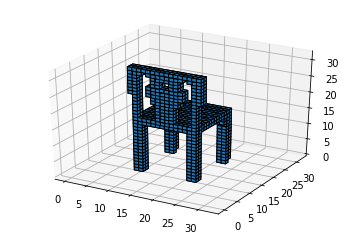

Predicted 3D object
Displaying the object


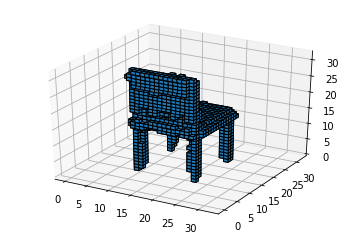

15
Real Image
torch.Size([1, 1, 128, 128])
Displaying the object


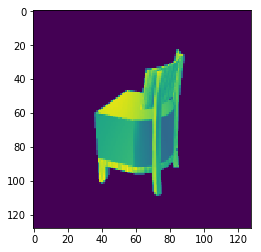

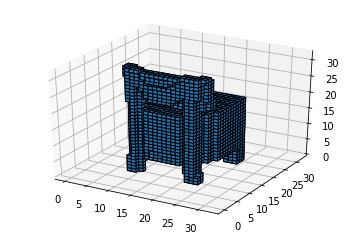

Predicted 3D object
Displaying the object


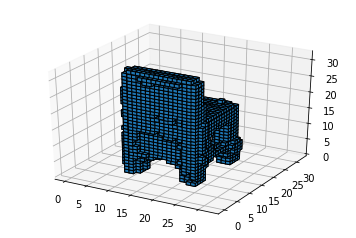

In [51]:
# Generate the 3D Object 
#Testing the general Structure of the VAE
import random
for j in range(0,3):
    i = random.randint(0,99)
    print(i)
    test_image = Variable(torch.FloatTensor(val_images[i][0])).view(1,1,128,128).cuda()
    print("Real Image")
    plt.imshow(test_image.squeeze().data.cpu().numpy())
    print(test_image.shape)
    test_latent = vae.encoder(test_image)[0]
    test_latent = test_latent.view(-1,vae.z_size,1,1,1)#latent.unsqueeze(2).unsqueeze(2).unsqueeze(2)
    test_object = vae.decoder(test_latent)
    test_object = test_object.squeeze().data.cpu().numpy()
    #print("Real 3D voxels")
    #print(val_voxels[i].shape)
    test_voxel = Variable(torch.FloatTensor(val_voxels[i])).data.cpu().numpy()
    display3DObject(test_voxel)
    print("Predicted 3D object")
    display3DObject(test_object >0.5)

Displaying the object


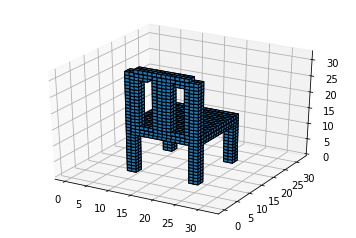

torch.Size([1, 1, 128, 128])
Real Image
Predicted 3D object
Displaying the object


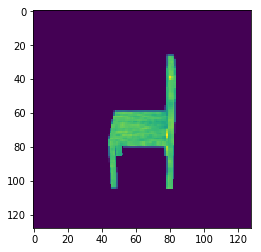

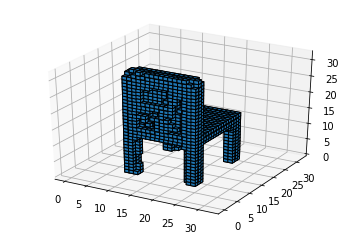

Variable containing:
 1437.6720
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Real Image
Predicted 3D object
Displaying the object


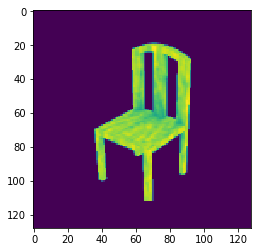

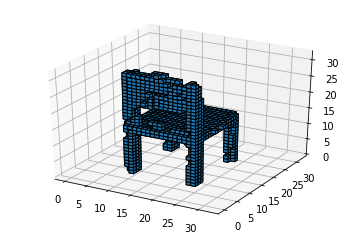

Variable containing:
 1429.9108
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Real Image
Predicted 3D object
Displaying the object


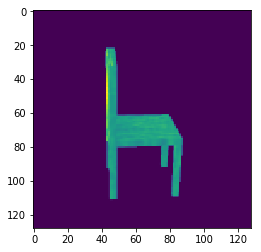

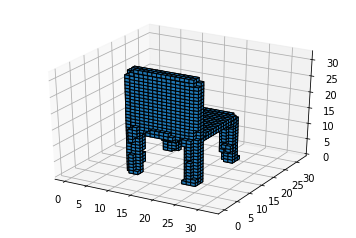

Variable containing:
 1140.4067
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Real Image
Predicted 3D object
Displaying the object


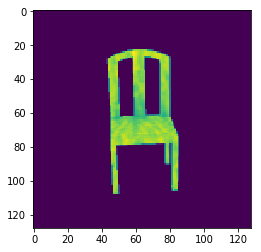

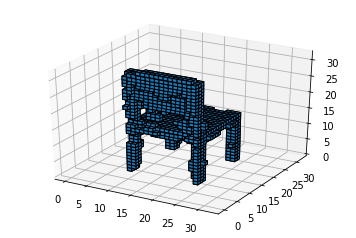

Variable containing:
 1544.5144
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Real Image
Predicted 3D object
Displaying the object


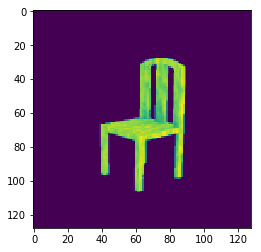

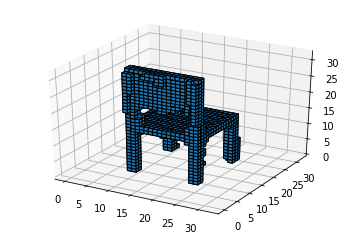

Variable containing:
 1139.4149
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Real Image
Predicted 3D object
Displaying the object


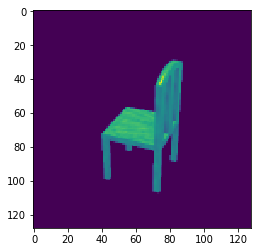

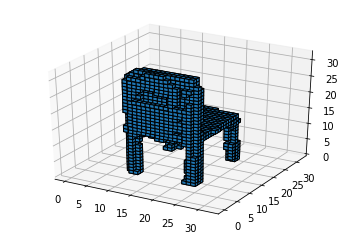

Variable containing:
 1341.5483
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Real Image
Predicted 3D object
Displaying the object


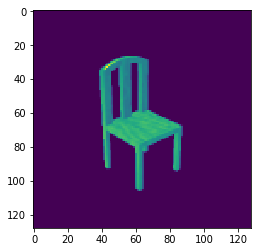

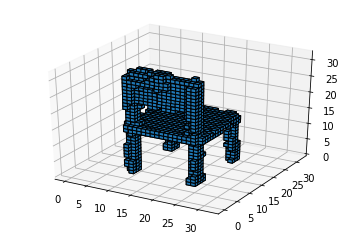

Variable containing:
 1377.3435
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Real Image
Predicted 3D object
Displaying the object


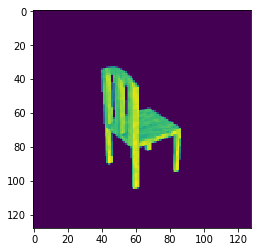

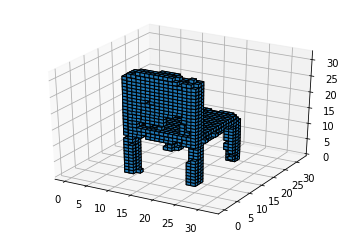

Variable containing:
 1434.3103
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Real Image
Predicted 3D object
Displaying the object


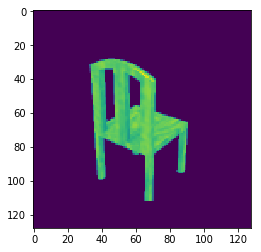

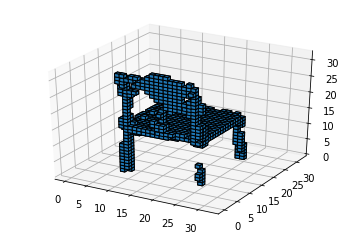

Variable containing:
 2161.0391
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Real Image
Predicted 3D object
Displaying the object


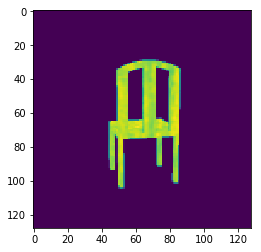

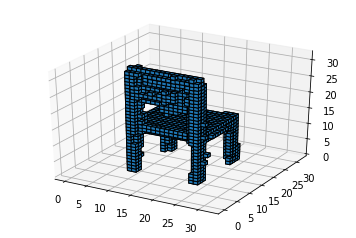

Variable containing:
 1316.4269
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Real Image
Predicted 3D object
Displaying the object


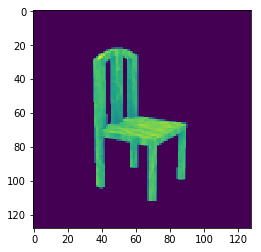

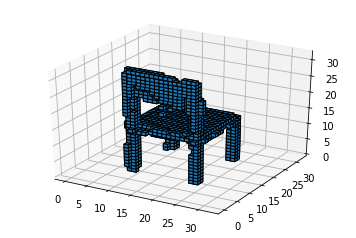

Variable containing:
 1467.1995
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Real Image
Predicted 3D object
Displaying the object


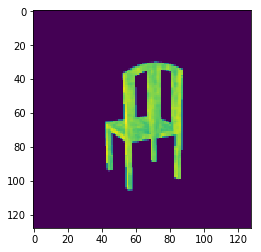

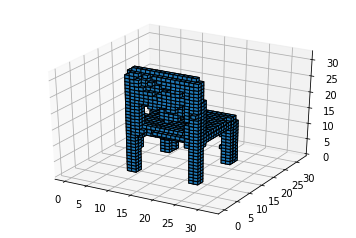

Variable containing:
 1093.7211
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Displaying the object


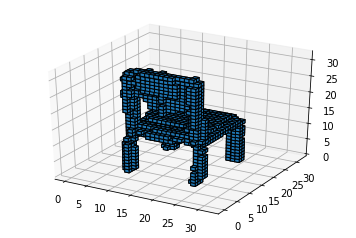

Variable containing:
 1470.9463
[torch.cuda.FloatTensor of size 1 (GPU 0)]



In [93]:
# Generate the 3D Object 
#Testing the general Structure of the VAE
#56
import random
i = 77#random.randint(0,99)
chair = val_images[i]
test_voxel = Variable(torch.FloatTensor(val_voxels[i]).cuda())
display3DObject(test_voxel.data.cpu().numpy())

test_images = Variable(torch.FloatTensor(chair)).view(12,1,128,128).cuda()

print(test_image.shape)
test_latent_means, test_latents_logvar = vae.encoder(test_images) 

test_latents = test_latent_means.view(-1,vae.z_size,1,1,1)#latent.unsqueeze(2).unsqueeze(2).unsqueeze(2)
pre_test_objects = vae.decoder(test_latents)
test_objects = pre_test_objects.squeeze().data.cpu().numpy()
    #print("Real 3D voxels")
    #print(val_voxels[i].shape)
for j in range(0,12):
    print("Real Image")
    plt.imshow(test_images[j].squeeze().data.cpu().numpy())
    print("Predicted 3D object")
    display3DObject(test_objects[j] >0.5)
    print(loss(pre_test_objects[j].squeeze(), test_voxel))
    
confident_indices = torch.min(test_latents_logvar, dim=0)[1]
confident_latent = test_latent_means.gather(0, confident_indices.view(1,-1))
confident_latent = confident_latent.view(-1,vae.z_size,1,1,1)#latent.unsqueeze(2).unsqueeze(2).unsqueeze(2)
pre_confident_object = vae.decoder(confident_latent)
confident_object = pre_confident_object.squeeze().data.cpu().numpy()
display3DObject(confident_object >0.5)
print(loss(pre_confident_object.squeeze(), test_voxel))